## Spectroscopy Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import math
from tqdm import tqdm
import lmfit

In [2]:
plt.rcParams.update({'font.size': 22})

### Exercise 1 - SDSS Data

In [3]:
files = glob.glob('../data/*.fits')
filename = files[0]
f = fits.open(filename)
print(repr(f[0].header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = 'r       '           / ICC version                                    
MJD     =                55539 / APO fMJD day at start of exposure              
MJDLIST = '55538 55539'        /                                                
NAME    = '4455-55537-01'      / The name of the currently loaded plate         
PLATEID =                 4455 / The currently loaded plate                     
TILEID  =                11103 /Cartridge used in this plugging                 
CARTID  =                   

In [4]:
plate = f[0].header['PLATEID']
mjd = f[0].header['MJD']
fiber = f[0].header['FIBERID']
print(f'PLATEID = {plate}\nMJD = {mjd}\nFIBERID = {fiber}')

PLATEID = 4455
MJD = 55539
FIBERID = 692


From here, we can see that the plate-mjd-fiber for this spectrum is 4455-55539-692. Plate represents the physical aluminum plate used to take this spectrum, MJD is the mean Julian date this spectrum was taken, and fiber is the optical fiber cable ID used to connect the plate to the sensors.

### Co-added Spectrum

In [5]:
print(repr(f[1].header))

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4619 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

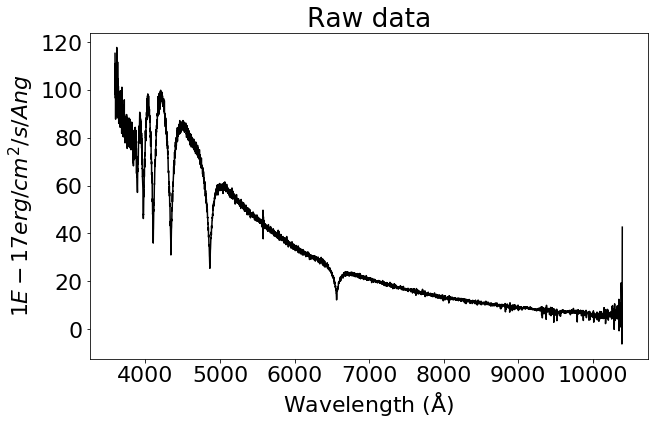

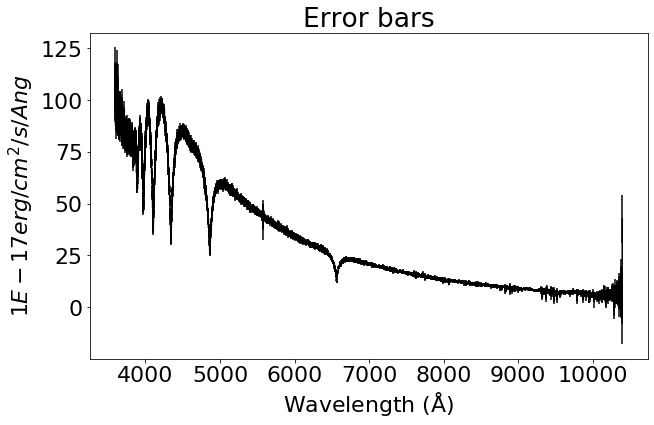

In [6]:
flux = f[1].data['flux']
flux_unit = f[0].header['BUNIT']
lmbd = 10**f[1].data['loglam']
ivar = f[1].data['ivar']

plt.figure(figsize=(10,6))
plt.ylabel('$%s$' % flux_unit)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.title('Raw data')
plt.plot(lmbd, flux, color='k')

plt.figure(figsize=(10,6))
plt.ylabel('$%s$' % flux_unit)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.title('Error bars')
plt.errorbar(lmbd, flux, yerr=np.sqrt(1/ivar), color='k');

### Exercise 2 - Individual Spectra

In [7]:
fluxes = [sp.data['flux'] for sp in f[4:-1]]
wls = [10**sp.data['loglam'] for sp in f[4:-1]]
ivars = [sp.data['ivar'] for sp in f[4:-1]]

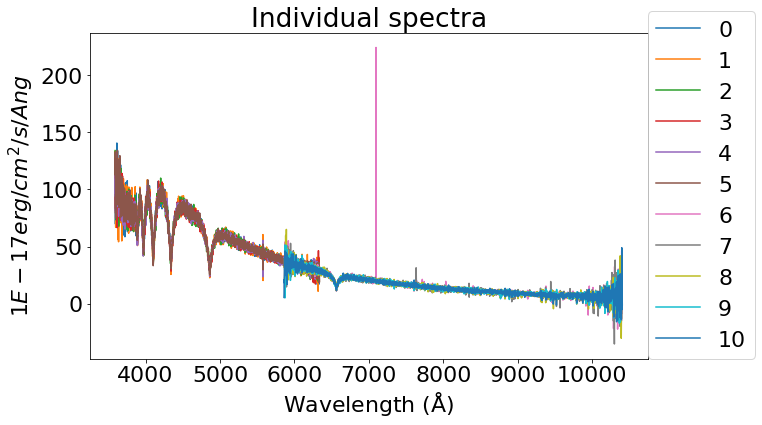

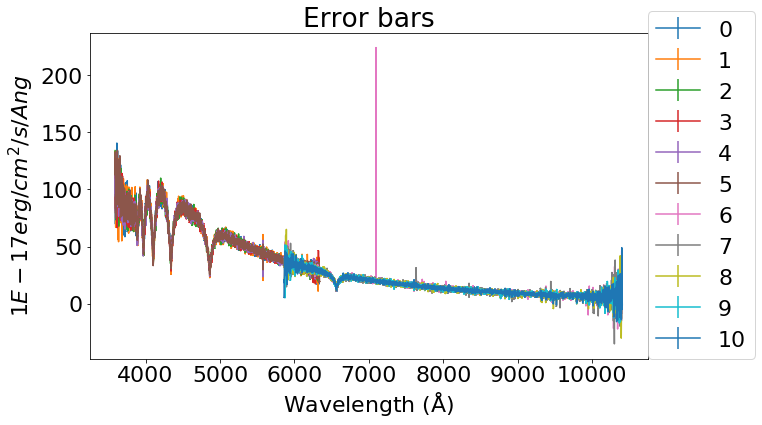

In [8]:
plt.figure(figsize=(10,6))
plt.ylabel('$%s$' % flux_unit)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.title('Individual spectra')
for i in range(len(fluxes)):
    plt.plot(wls[i], fluxes[i], label=str(i))
plt.legend(loc=(1,0))

plt.figure(figsize=(10,6))
plt.ylabel('$%s$' % flux_unit)
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.title('Error bars')
for i in range(len(fluxes)):
    plt.errorbar(wls[i], fluxes[i], yerr=np.sqrt(ivars[i]), label=str(i))
plt.legend(loc=(1,0));

### Fitting initialization

In [9]:
def residual(params, x, data, ivar):
    return (data-model(x, params['coeff'], params['temp']))*np.sqrt(ivar)

def model(x, coeff, temp):
    return coeff/(x**5 * np.expm1(1.4394e-2/x/temp))

params = lmfit.Parameters()
params.add('coeff', value=1e-22)
params.add('temp', value=1e5, min=1e3, max=1e8)

### Exercise 3 - Continuum Normalization

In [10]:
balmer = np.array([6563, 4861, 4340, 4102])/1e10 # m
window = 40
abs_frac = 0.4
x = lmbd/1e10
y = flux

wavelength: 6563 A	coeff: 5.610447545475068e-30	temp: 20588.754861401987 K

wavelength: 4861 A	coeff: 2.2916962180364934e-30	temp: 33605.282089926535 K

wavelength: 4340 A	coeff: 4.109801435241816e-30	temp: 22923.479037928835 K

wavelength: 4102 A	coeff: 3.418929243140865e-28	temp: 6064.919072659814 K



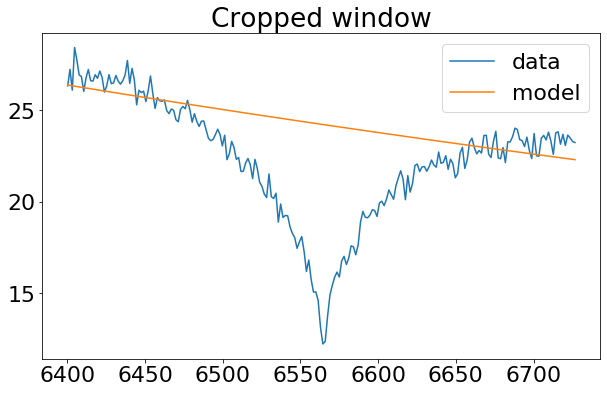

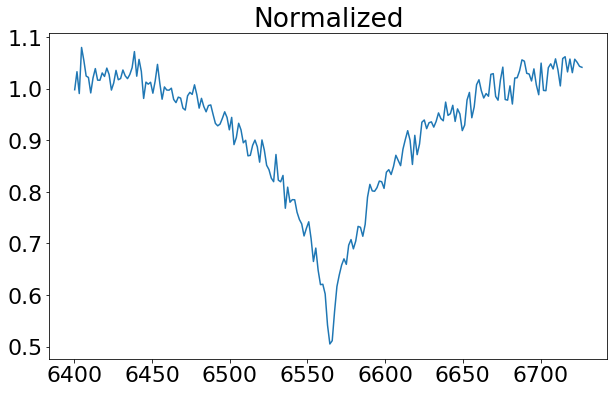

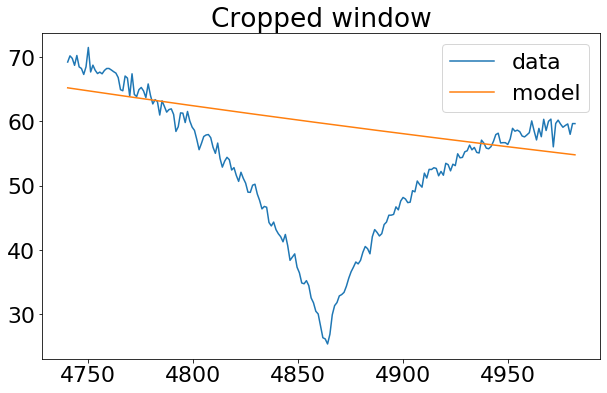

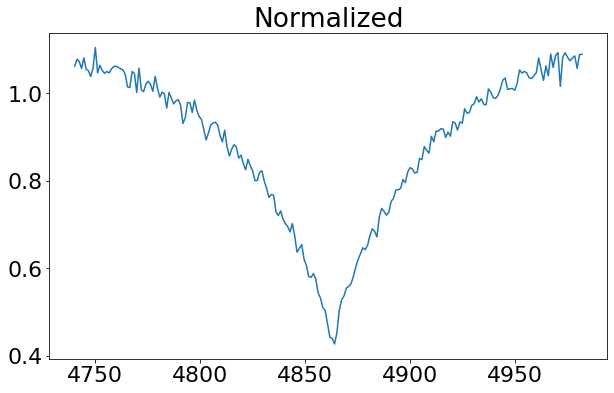

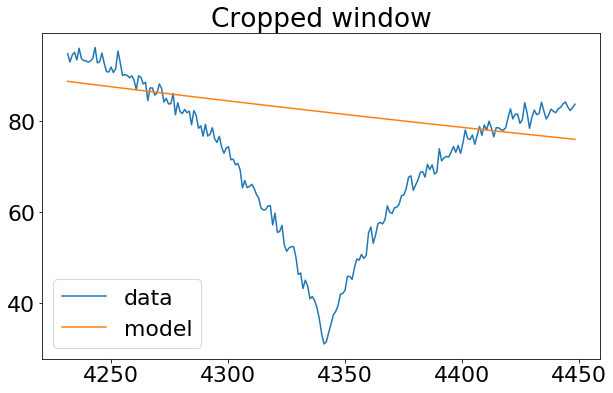

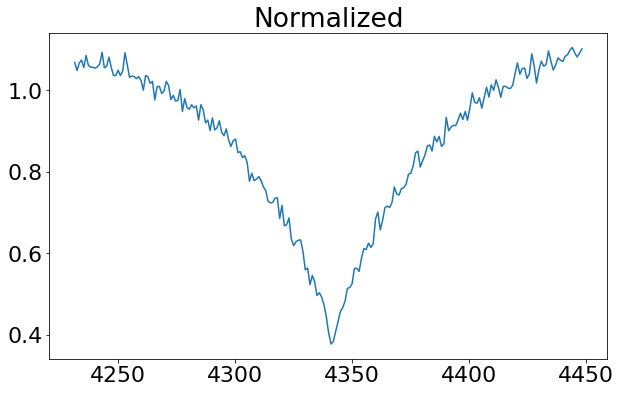

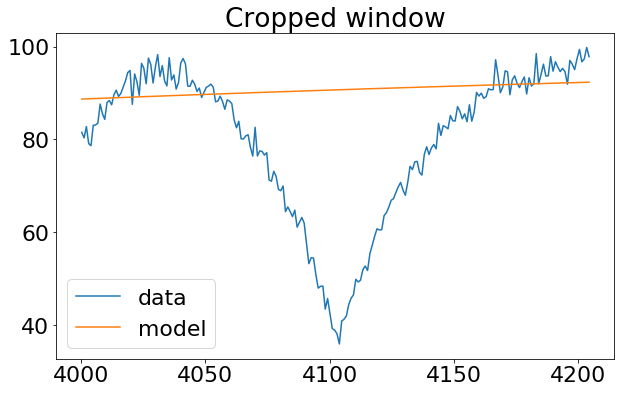

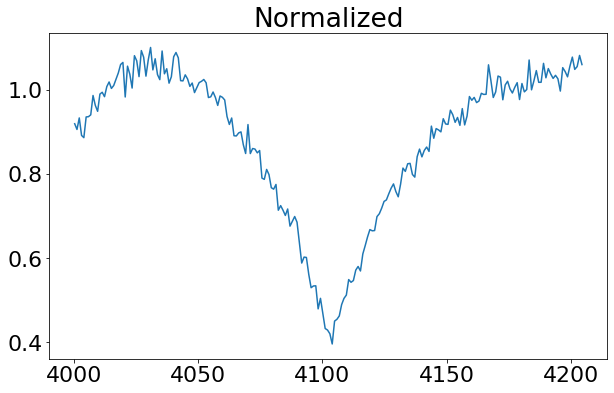

In [11]:
for center in balmer:
    # cropping to window
    ldx, rdx = np.searchsorted(x, (center*(1-1/window), center*(1+1/window)))
    x_crop = x[ldx:rdx]
    y_crop = y[ldx:rdx]
    ivar_crop = ivar[ldx:rdx]
    
    # cropping to non-absorption line
    ldx, rdx = np.searchsorted(x_crop, (center*(1-abs_frac/window), center*(1+abs_frac/window)))
    x_nabs = np.concatenate((x_crop[0:ldx], x_crop[rdx:]))
    y_nabs = np.concatenate((y_crop[0:ldx], y_crop[rdx:]))
    ivar_nabs = np.concatenate((ivar_crop[:ldx], ivar_crop[rdx:]))
    
    # fitting function
    out = lmfit.minimize(residual, params, args=(x_nabs, y_nabs, ivar_nabs))
    vals = out.params
    print(f"wavelength: {int(center*1e10)} A\tcoeff: {vals['coeff'].value}\ttemp: {vals['temp'].value} K\n")
    
    # calculate expected
    y_expc = model(x_crop, vals['coeff'], vals['temp'])
    y_norm = y_crop/y_expc
    
    # plot results
    plt.figure(figsize=(10,6))
    plt.title('Cropped window')
    plt.plot(x_crop*1e10, y_crop, label='data')
    plt.plot(x_crop*1e10, y_expc, label='model')
    plt.legend()
    
    plt.figure(figsize=(10,6))
    plt.title('Normalized')
    plt.plot(x_crop*1e10, y_norm)

The four curves actually disagree with one another quite a lot! Windows $1$ and $3$ both have results that relatively agree with the overall fit (see below), but they are still not very great. Window $2$ actually overestimates the surface temperature by nearly double, while window $4$ underestimates the temperature by a factor of three. I would attribute this to the cropping method used: since the later Balmer lines are closer together and interact with more absorption lines, I decided to use a window size proportional to the wavelength of each line. However, in the case of the H$\alpha$ line, the window seems a bit too small, while for the other lines, the window seems too large. To achieve the goal of automation, some precision and accuracy was sacrificed, since it cannot be expected for a human to specify the crop window for each separate absorption line on every spectrum.

### Exercise 4 - Fitting Blackbody Radiation Curve

In [12]:
idxs = np.searchsorted(lmbd, (5100, 6100, 6800, 9000))
x_crop = np.concatenate((lmbd[idxs[0]:idxs[1]], lmbd[idxs[2]:idxs[3]]))/1e10
y_crop = np.concatenate((flux[idxs[0]:idxs[1]], flux[idxs[2]:idxs[3]]))
ivar_crop = np.concatenate((ivar[idxs[0]:idxs[1]], ivar[idxs[2]:idxs[3]]))

out = lmfit.minimize(residual, params, args=(x_crop, y_crop, ivar_crop))
out

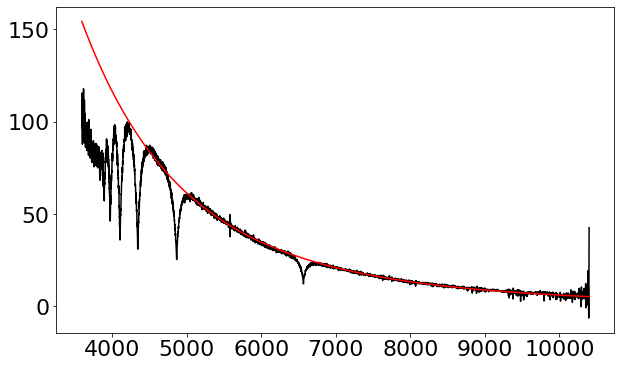

In [13]:
vals = out.params
y_expc = model((lmbd/1e10), vals['coeff'], vals['temp'])
plt.figure(figsize=(10,6))
plt.plot(lmbd, flux, color='k', label='data')
plt.plot(lmbd, y_expc, color='r', label='model');

As can be seen, the `lmfit` model does a good job of predicting the overall blackbody curve when a human inspects the curve to manually remove the major absorption lines.

### Using overall fit for normalization

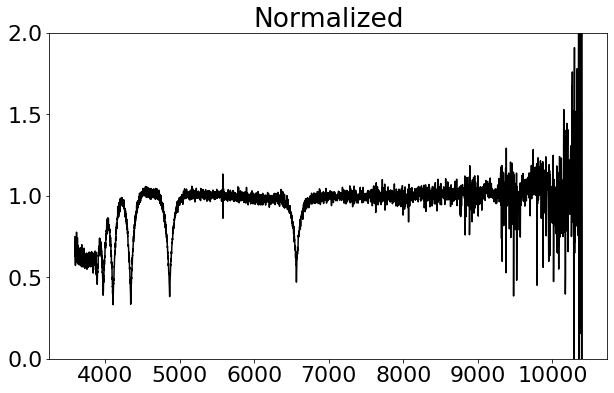

In [14]:
y_norm = flux/y_expc
plt.figure(figsize=(10,6))
plt.title('Normalized')
plt.ylim((0,2))
plt.plot(lmbd, y_norm, 'k');

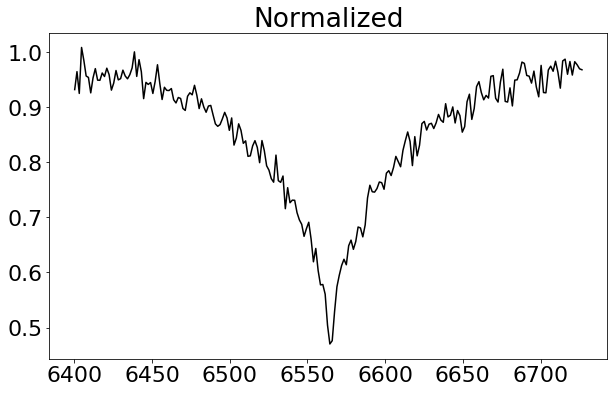

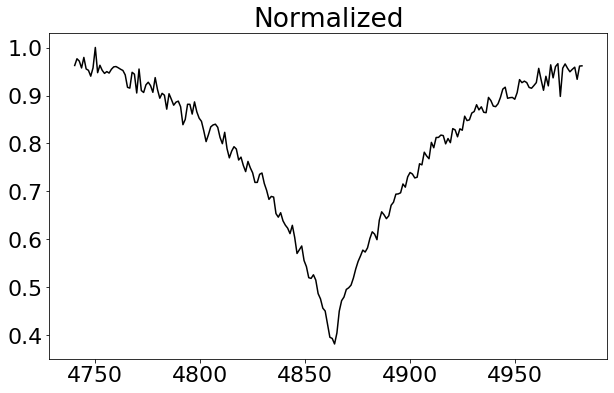

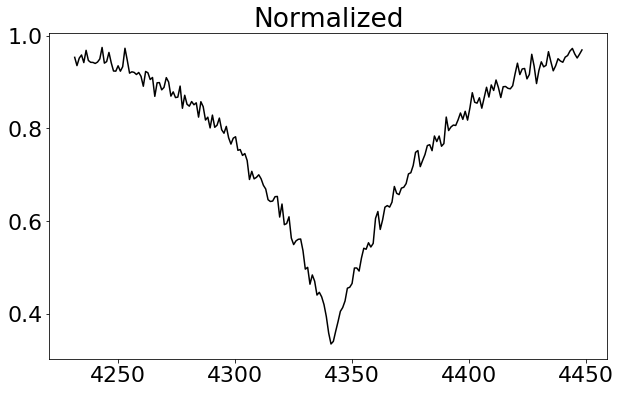

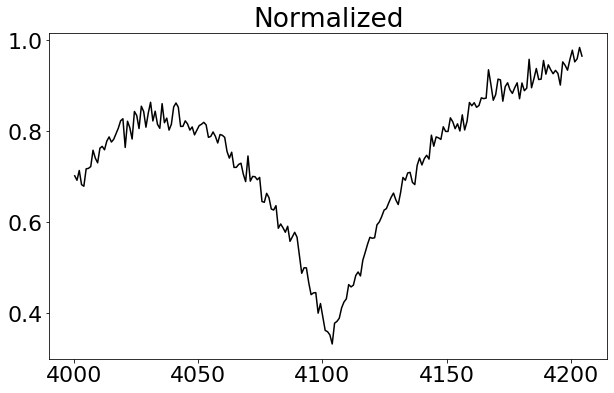

In [15]:
for center in balmer:
    ldx, rdx = np.searchsorted(x, (center*(1-1/window), center*(1+1/window)))
    x_crop = x[ldx:rdx]
    y_crop = y_norm[ldx:rdx]
    
    plt.figure(figsize=(10,6))
    plt.title('Normalized')
    plt.plot(x_crop*1e10, y_crop, 'k')